#### Leon Henne, 22.02.2022
# Data Exploration Project Notebook
## Predicting the survivability of the Titanic passengers

### **Setup der Packages und Laden der Model Datei**

In [1]:
'''loading und unzipping the model from a github gist'''
!wget "https://gist.github.com/LeonHenne/3ac8385ac4efa7768a42ba0b8795a0ba/raw/ab12305857324235751846d3a597f1ba07e86644/knn_model.zip" --quiet
!unzip knn_model.zip

Archive:  knn_model.zip
   creating: knn_model/
  inflating: knn_model/requirements.txt  
  inflating: knn_model/MLmodel       
  inflating: knn_model/model.pkl     
  inflating: knn_model/conda.yaml    


In [2]:
!pip install -r "/content/knn_model/requirements.txt" --quiet

     |████████████████████████████████| 16.5 MB 189 kB/s 
     |████████████████████████████████| 79 kB 7.1 MB/s 
     |████████████████████████████████| 58 kB 5.0 MB/s 
     |████████████████████████████████| 596 kB 28.4 MB/s 
     |████████████████████████████████| 210 kB 49.1 MB/s 
     |████████████████████████████████| 181 kB 46.1 MB/s 
     |████████████████████████████████| 146 kB 24.4 MB/s 
     |████████████████████████████████| 54 kB 2.3 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
     |████████████████████████████████| 78 kB 5.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
gym 0.17.3 requires cloudpickle<1.7.0,>=1.2.0, but you have cloudpickle 2.0.0 which is incompatible.
arviz 0.11.4 requires typing-extensions<4,>=3.7.4.3, but you 

In [3]:
'''installing the requirements twice to downgrade packages'''
!pip install -r "/content/knn_model/requirements.txt" --quiet

In [4]:
!pip install pickle5 --quiet

     |████████████████████████████████| 256 kB 4.0 MB/s 


In [5]:
!pip install mlflow --quiet

In [6]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import mlflow
import pickle5 as pickle

### **Erläuterung und Vorstellung des Datensatzes**


In [7]:
'''reading the titanic data (https://www.kaggle.com/c/titanic) from a created github gist'''
df = pd.read_csv("https://gist.githubusercontent.com/Inwernos/e005f7f0d18d57b256404cff3ce3e690/raw/99ca254b56826910b640ce0719e2fcc89ad1a3a4/titanic.csv")
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


#### Datensatz Visualisierungen

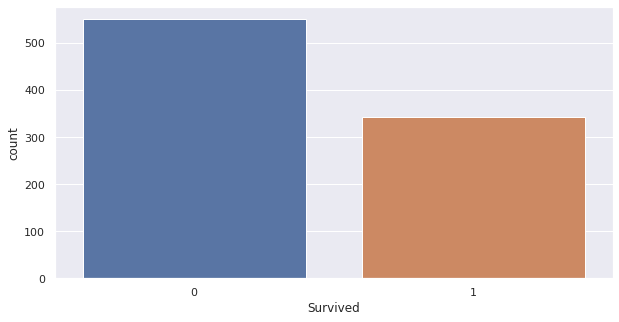

In [9]:
'''presenting the overall distribution of survivors and deceased'''
sns.set(rc = {'figure.figsize':(10,5)})
survivorship_distribution = sns.countplot(x= "Survived", data = df)

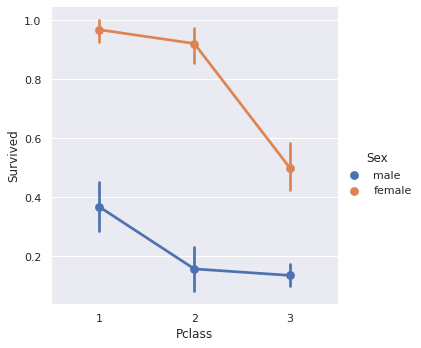

In [10]:
'''showing the survivability depending on Class and Sex'''
sns.set(rc = {'figure.figsize':(10,5)})
sns.catplot(x="Pclass", y="Survived", hue="Sex",
            kind="point", data=df)

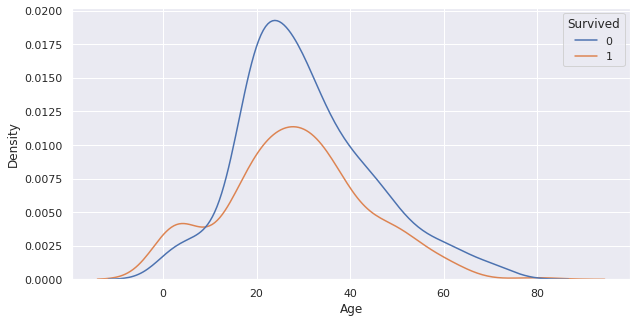

In [11]:
'''showing the distribution of age on survivors and deceased'''
sns.set(rc = {'figure.figsize':(10,5)})
age_distribution = sns.kdeplot(data = df, x = 'Age', hue = 'Survived')

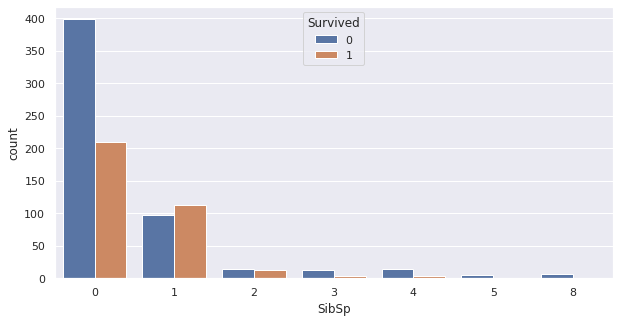

In [12]:
'''visualizing the number of survivors and deceased grouped by their number of siblings and spouses'''
sns.set(rc = {'figure.figsize':(10,5)})
SibSp_survivorship = sns.countplot(data = df, x="SibSp", hue="Survived")

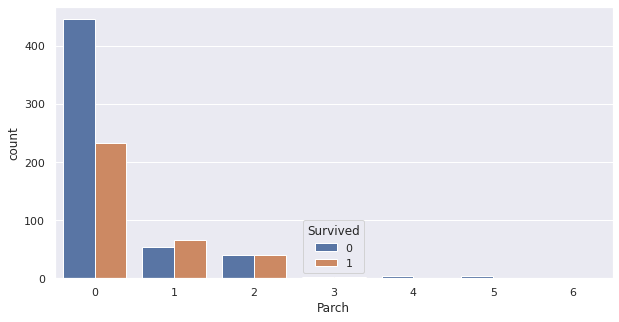

In [13]:
'''visualizing the number of survivors and deceased grouped by their number of parents and children'''
sns.set(rc = {'figure.figsize':(10,5)})
Parch_survivorship = sns.countplot(data = df, x="Parch", hue="Survived") 

### **Laden des KNN Models**

In [14]:
logged_model = "/content/knn_model"

with open(logged_model+"/MLmodel", 'r', encoding = 'utf-8') as f:
   model_run_id = f.read()[309:350]
   print(model_run_id)

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

run_id: d51c7a19574240ecb8e03559d9b61a82



### **Testen des Models auf den Testdaten**

In [15]:
test_df = pd.read_csv("https://gist.githubusercontent.com/Inwernos/718cbf951b7c5bfc7060801824e64a3c/raw/42fec3053c3532fd521403302bc9e00714e3a26d/Titanic_test_dataset.csv")
x_test=test_df.drop('Survived', axis = 1)
scaler= StandardScaler()
scaler.fit(x_test)
x_test= scaler.transform(x_test)
y_test=test_df['Survived']

In [16]:
#using the loaded model to predict the test data
y_predicted = loaded_model.predict(x_test)
#calculating the metrices
accuracy = accuracy_score(y_test,y_predicted)
matrix = confusion_matrix(y_test,y_predicted)

print(accuracy)

0.8100558659217877


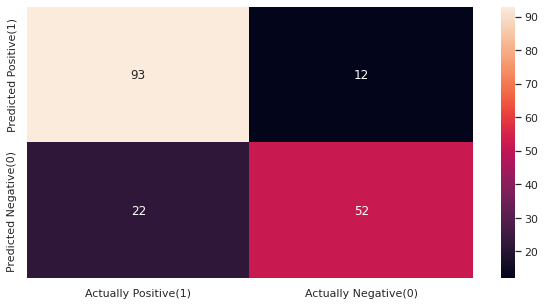

In [17]:
df_cm = pd.DataFrame(matrix, index = ["Predicted Positive(1)","Predicted Negative(0)"],
                  columns = ["Actually Positive(1)","Actually Negative(0)"])
sns.heatmap(df_cm, annot=True)

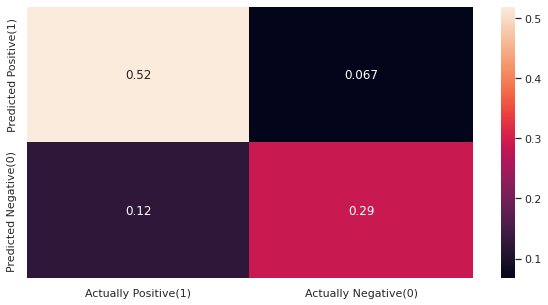

In [18]:
matrix_rates = [[0,0],[0,0]]
for i in range(len(matrix)):
  for j in range(len(matrix[i])):
    matrix_rates[i][j] = matrix[i][j] / len(y_test)

df_cm = pd.DataFrame(matrix_rates, index = ["Predicted Positive(1)","Predicted Negative(0)"],
                  columns = ["Actually Positive(1)","Actually Negative(0)"])
sns.heatmap(df_cm, annot=True)